<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/experimentation/Kalman_Filters_for_Nifty_ema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b
!pip install ffn

In [83]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
import ffn
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

[*********************100%***********************]  1 of 1 completed


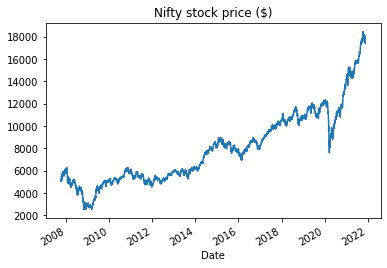

In [84]:
nifty_df = yf.download('^nsei',start='2007-10-01') # 2018
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [85]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [86]:
df = nifty_df[['Adj Close']]


mean 16071.569544664157


Text(0.5, 0, 'Days')

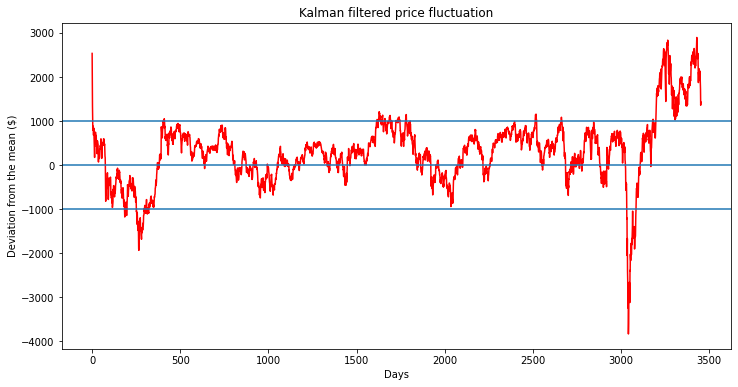

In [87]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance = 1,
                  transition_covariance = 0.0001)#.0001
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')

plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [88]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [89]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(fast=65,slow=100,signal=36, append=True)

print()

In [90]:
nifty=nifty.set_index('date')

In [91]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_65_100_36,MACDh_65_100_36,MACDs_65_100_36
date,,,,,,,,
2021-11-22,1359.370805,2098.723199,286.764335,2242.105367,1955.341031,60.971250,-35.000057,95.971308
2021-11-23,1431.780065,2044.438833,305.473963,2197.175815,1891.701852,52.144054,-41.458213,93.602267


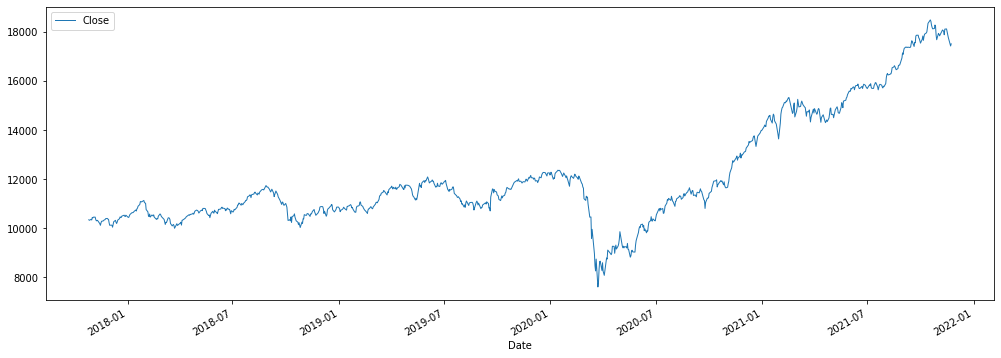

In [92]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

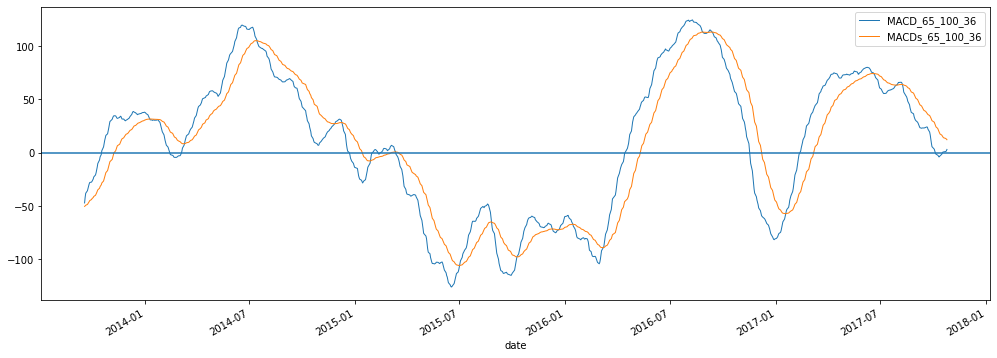

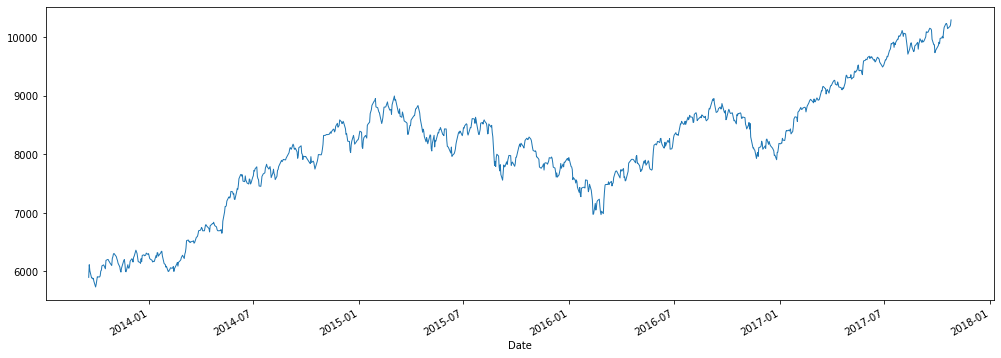

In [93]:
nifty[['MACD_65_100_36','MACDs_65_100_36']][-2000:-1000].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0);
plt.show()
nifty_df['Close'][-2000:-1000].plot(figsize=(17,6),linewidth=1);


In [94]:
nifty['slope']=abs(nifty['MACD_65_100_36'].diff(5))
nifty['slope']=np.where(nifty['slope']<=3,0,nifty['slope'])
nifty['slope_s']=abs(nifty['MACDs_65_100_36'].diff(5))
nifty['slope_s']=np.where(nifty['slope_s']<=3,0,nifty['slope_s'])

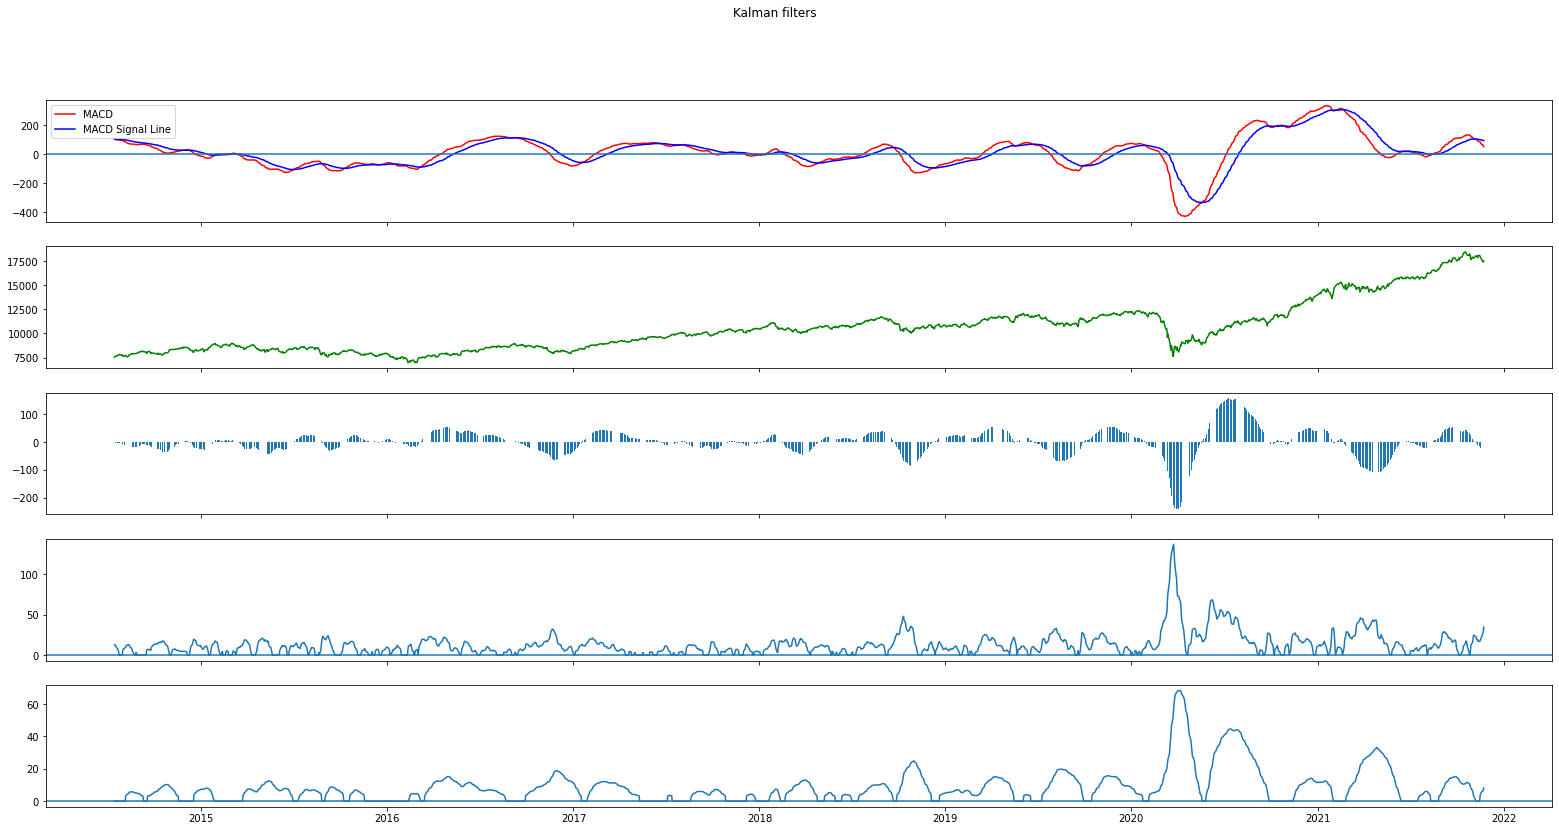

In [95]:
fig, ax = plt.subplots(5,1,figsize=(27,13),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[-1800:], nifty.loc[:, 'MACD_65_100_36'][-1800:],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[-1800:], nifty.loc[:, 'MACDs_65_100_36'][-1800:],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[-1800:], nifty.loc[:, 'MACDh_65_100_36'][-1800:], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[-1800:], nifty_df.loc[:, 'Close'][-1800:],'g', label='NH moving avg 50 days')
ax[3].plot(nifty.iloc[:, :].index[-1800:], nifty.loc[:, 'slope'][-1800:], label='Slope')
ax[4].plot(nifty.iloc[:, :].index[-1800:], nifty.loc[:, 'slope_s'][-1800:], label='Slope')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[3].axhline(y=0)
ax[4].axhline(y=0)
ax[0].legend(loc='upper left')
plt.show()


In [96]:
nifty.tail(1)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_65_100_36,MACDh_65_100_36,MACDs_65_100_36,slope,slope_s
date,,,,,,,,,,
2021-11-23,1431.780065,2044.438833,305.473963,2197.175815,1891.701852,52.144054,-41.458213,93.602267,34.600902,8.196659


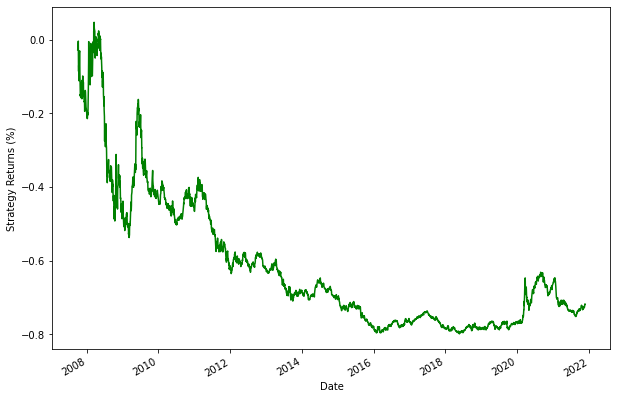

sharpe ratio :  -0.20746197071807337
sortino ratio :  -0.21271890825946588


In [97]:
nifty['signals']=np.where(nifty['MACDh_65_100_36']>0,1,-1)
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05/252) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)
std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05/252)/std_neg
print('sortino ratio : ' , sortino_ratio) 

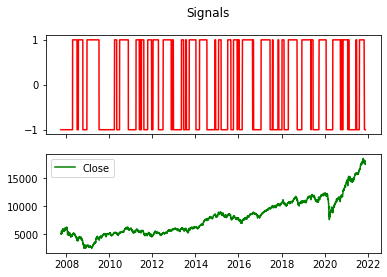

In [98]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'signals'],'r', label='Signals')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='Close')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[1].legend()
plt.show()


In [99]:
stats = geometric_returns.calc_stats()  # use .calc_stats() on a series to invoke ffn.
stats.display()

Stats for Strategy_F from 2007-10-01 00:00:00 - 2021-11-23 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
-                  -0.11  25.80%  -1812.08%

Annualized Returns:
mtd     3m      6m      ytd    1y     3y      5y      10y    incep.
------  ------  ------  -----  -----  ------  ------  -----  --------
-1.99%  -4.31%  -0.89%  8.43%  4.42%  -2.81%  -1.13%  1.75%  25.80%

Periodic:
        daily      monthly    yearly
------  ---------  ---------  --------
sharpe  -0.11      -0.11      0.36
mean    -81.81%    -19.28%    13.62%
vol     715.06%    181.58%    37.91%
skew    -1.77      -4.33      3.21
kurt    456.20     68.50      11.12
best    1089.50%   347.64%    139.51%
worst   -1186.20%  -517.37%   -13.65%

Drawdowns:
max        avg         # days
---------  --------  --------
-1812.08%  -643.65%      1719

Misc:
---------------  -------
avg. up month    8.98%
avg. down month 

In [100]:
stats.stats

start                    2007-10-01 00:00:00
end                      2021-11-23 00:00:00
rf                                         0
total_return                             NaN
cagr                                0.257961
max_drawdown                        -18.1208
calmar                             0.0142356
mtd                               -0.0199236
three_month                       -0.0431149
six_month                        -0.00886926
ytd                                0.0843173
one_year                           0.0441584
three_year                        -0.0281418
five_year                         -0.0112511
ten_year                            0.017509
incep                               0.257961
daily_sharpe                       -0.114416
daily_sortino                      -0.154767
daily_mean                         -0.818141
daily_vol                             7.1506
daily_skew                          -1.77489
daily_kurt                           456.202
best_day  

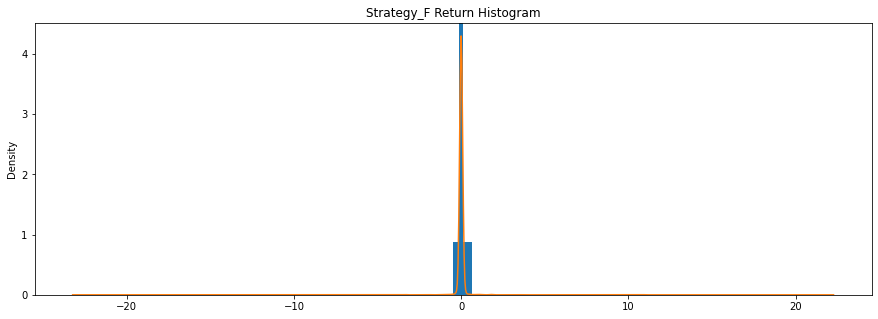

In [101]:
stats.plot_histogram()

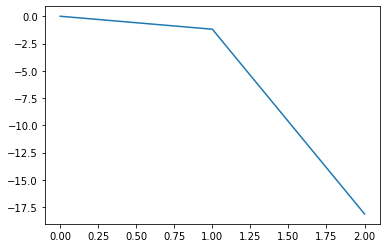

In [102]:
stats.drawdown_details['drawdown'].plot();

In [103]:
stats.display_monthly_returns()

  Year     Jan    Feb     Mar      Apr      May     Jun    Jul    Aug     Sep     Oct    Nov    Dec     YTD
------  ------  -----  ------  -------  -------  ------  -----  -----  ------  ------  -----  -----  ------
  2007    0      0       0        0        0       0      0      0       0     446.76  -9.64  41.21  597.68
  2008  -68.3   42.93  -88.19  -207.14  -517.37  347.64  75.75  -1.07   17.62   -5.59  -3.16  19.63  139.51
  2009    3.25   4.14   -9.21   -17.85   -46.78   14.23  56.91   2.12   14.74  -10.57  11.41  -1.15  -11.72
  2010   -2.37   1.6    11.86    -0.65     3.13    5.51  -1.06  -0.68  -12.26    0.27   2.36   5.91   12.43
  2011  -12.78  -4.11    9.12     1.97     9.92    9.14   2.72   5.71   -0.5    -1.47   7.55   3.38   32.14
  2012   -1.01  -2.31    1.14     1.67    -4.06    4.95   0.59  -0.35   -5.29    1.05   4.21   1.37    1.46
  2013    1.35  -3.45   -0.04     2.81     2.2     4.15   4.08  -1.69    4.07   -4.03   0.92  -0.94    9.37
  2014    0.43   1.43    0.3